In [2]:
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import mlflow
import vecnn
import time
import hnswlib
import faiss
from typing import Any, Tuple

def mlflow_all_experiments(tracking_uri="./mlruns"):
    client = mlflow.tracking.MlflowClient(tracking_uri=tracking_uri)
    experiment_ids = [e.experiment_id for e in client.search_experiments()]
    records = []
    for id in experiment_ids:
        records.extend(mlflow_experiment_records(id, client))
    df = pd.DataFrame.from_records(records)
    return df

def mlflow_experiment(name: str, tracking_uri="./mlruns") -> pd.DataFrame | None:
    client = mlflow.tracking.MlflowClient(tracking_uri=tracking_uri)
    experiment_ids = [e.experiment_id for e in client.search_experiments() if e.name == name] # filter_string=f"name = '{name}'"
    if len(experiment_ids) == 0:
        return None
    records = mlflow_experiment_records(experiment_ids[0], client)
    df = pd.DataFrame.from_records(records)
    return df

# remove stupid columns
def mlflow_experiment_stripped(name: str, tracking_uri="./mlruns") -> pd.DataFrame | None:
    df = mlflow_experiment(name=name, tracking_uri=tracking_uri)
    if df is None:
        return None
    forbidden_cols = ["ex_artifact_location", "ex_creation_time", "ex_experiment_id", "ex_last_update_time", "ex_lifecycle_stage", "ex_tags", "tag_mlflow.source.type", "tag_mlflow.user", "tag_mlflow.runName", "tag_mlflow.source.name"]
    df = df.drop(columns=[col for col in forbidden_cols if col in df.columns])
    
    # numeric_cols = ["p_data_n", "p_knn_k", "p_data_dims", "m_search_recall", "m_build_time",	m_search_time	m_build_ndc	m_search_ndc]
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    return df


def mlflow_experiment_records(id: str, client: mlflow.client.MlflowClient) -> dict:
    records = []
    exp = client.get_experiment(id)
    runs = client.search_runs(id)
    ex_record = dict()
    for (k,v) in exp:
        ex_record[f"ex_{k}"] = v

    for r in runs:
        record = {**ex_record}
        for k in r.data.params:
            record[f"p_{k}"] = r.data.params[k]
        for k in r.data.metrics:
            record[f"m_{k}"] = r.data.metrics[k]
        for k in r.data.tags:
            record[f"tag_{k}"] = r.data.tags[k]
        records.append(record)
    return records



def mlflow_fresh_experiment(experiment_name: str): 
    mlflow.set_tracking_uri("./mlruns")

    existing = mlflow.search_experiments(filter_string=f"name = '{experiment_name}'")
    if len(existing) != 0:
        mlflow.delete_experiment(existing[0].experiment_id)
    mlflow.set_experiment(experiment_name=experiment_name)


# ndc = number of distance calculations
def mlflow_log_model(model_name: str, data_n: str, data_dims: str, knn_k: str, build_time: float, build_ndc: float | None, search_time: float, search_ndc: float | None, search_recall: float, **kwargs):
    with mlflow.start_run():
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("data_n", data_n)
        mlflow.log_param("data_dims", data_dims)
        mlflow.log_param("knn_k", knn_k)
        if build_ndc is not None:
            mlflow.log_metric("build_ndc", build_ndc)
        mlflow.log_metric("build_time", build_time)
        mlflow.log_metric("search_time", search_time)
        if search_ndc is not None:
            mlflow.log_metric("search_ndc", search_ndc)
        mlflow.log_metric("search_recall", search_recall)
        
        for key, value in kwargs.items():
            mlflow.log_param(key, value)

In [2]:
from dataclasses import dataclass, field
from typing import Literal, Optional, Callable, Tuple

@dataclass
class ModelParams:
    model: Literal['vecnn_hsnw', 'vecnn_transition', 'vecnn_vptree', 'scipy_kdtree', 'hnswlib_hnsw', 'rustcv_hnsw', 'faiss_hnsw', 'rustcv_hnsw']
    level_norm_param: Optional[float] = None
    ef_construction: Optional[int] = None
    m_max: Optional[int] = None
    m_max_0: Optional[int] = None

@dataclass
class BuildMetrics: 
    build_time: float # in seconds
    num_distance_calculations: Optional[int] = None

@dataclass
class SearchMetrics: 
    search_time: float # in seconds
    recall: float # from 0.0 to 1.0
    num_distance_calculations: Optional[int] = None

class Model:
    build_metrics: BuildMetrics
    params: ModelParams

    def __init__(self, data: np.ndarray, params: ModelParams):
        n, dim = data.shape
        self.params = params
        if params.model == 'vecnn_vptree':
            dataset = vecnn.Dataset(data) # not ideal
            start = time.time()
            vptree = vecnn.VpTree(dataset)
            build_time =  time.time() - start
            self.build_metrics = BuildMetrics(build_time=build_time, num_distance_calculations=vptree.num_distance_calculations_in_build)
            self.vecnn_vptree = vptree
        elif params.model == 'vecnn_hnsw':
            if params.level_norm_param is None or params.ef_construction is None or params.m_max is None or params.m_max_0 is None:
                raise f"for vecnn_hsnw, these params cannot be None: (level_norm_param: {params.level_norm_param}, ef_construction: {params.ef_construction}, m_max: {params.m_max}, m_max_0: {params.m_max_0})"
            dataset = vecnn.Dataset(data) # not ideal
            start = time.time()
            hnsw = vecnn.Hnsw(dataset, params=vecnn.HnswParams(params.level_norm_param, params.ef_construction, params.m_max, params.m_max_0))
            build_time =  time.time() - start
            self.build_metrics =  BuildMetrics(build_time=build_time, num_distance_calculations=hnsw.num_distance_calculations_in_build)
            self.vecnn_hsnw = hnsw
        elif params.model == 'vecnn_transition':
            dataset = vecnn.Dataset(data) # not ideal
            start = time.time()
            hnsw = vecnn.build_hnsw_by_transition(dataset, vecnn.TransitionParams(32, 20, 0.2))
            build_time = time.time() - start
            self.build_metrics =  BuildMetrics(build_time=build_time, num_distance_calculations=hnsw.num_distance_calculations_in_build)
            self.vecnn_hsnw = hnsw
        elif params.model == 'rustcv_hnsw':
            dataset = vecnn.Dataset(data) # not ideal
            start = time.time()
            hnsw = vecnn.RustCvHnsw(dataset, params.ef_construction)
            build_time =  time.time() - start
            self.build_metrics =  BuildMetrics(build_time=build_time)
            self.rustcv_hnsw = hnsw
        elif params.model == 'scipy_kdtree':
            start = time.time()
            scipy_kdtree = cKDTree(data)
            build_time =  time.time() - start
            self.build_metrics =  BuildMetrics(build_time=build_time)
            self.scipy_kdtree = scipy_kdtree
        elif params.model == 'faiss_hnsw':
            start = time.time()
            faiss_hnsw = faiss.IndexHNSWFlat(dim, params.m_max) 
            faiss_hnsw.hnsw.efConstruction = params.ef_construction
            faiss_hnsw.add(data)
            build_time = time.time() - start
            self.build_metrics =  BuildMetrics(build_time=build_time)
            self.faiss_hnsw = faiss_hnsw
            faiss_hnsw.hnsw.efSearch = 20 #todo!
        elif params.model == 'hnswlib_hnsw':
            ids = np.arange(n)
            start = time.time()
            hnswlib_hnsw = hnswlib.Index(space = 'l2', dim = dim) 
            hnswlib_hnsw.init_index(max_elements = n, ef_construction = params.ef_construction, M = params.m_max)
            hnswlib_hnsw.add_items(data, ids)
            hnswlib_hnsw.set_ef(20) #todo!
            build_time =  time.time() - start
            self.build_metrics =  BuildMetrics(build_time=build_time)
            self.hnswlib_hnsw = hnswlib_hnsw
        
            
        else: 
            raise Exception(f"Invalid 'model' type string provided: {params.model}")


    def single_row_knn_fn(self) -> Callable[[np.array, int], Tuple[np.array, float, Optional[int]]]:
        """depending on model inside this class, returns a closure with this signature:

        fn(q: 1-d np.array of float32, k: int) -> 
            indices: 1-d np.array of uint64,
            search_tiem: float, 
            num_distance_calculations: int | None
        
        """
        model = self.params.model
        if model == 'vecnn_vptree':
            def knn(query: np.ndarray, k: int) -> Tuple[np.ndarray, float, Optional[int]]:
                start = time.time()
                res = self.vecnn_vptree.knn(query, k)
                search_time = time.time() - start
                return (res.indices, search_time, res.num_distance_calculations)
            return knn
        elif model == 'vecnn_hnsw' or model == 'vecnn_transition':
            def knn(query: np.ndarray, k: int) -> Tuple[np.ndarray, float, Optional[int]]:
                start = time.time()
                res = self.vecnn_hsnw.knn(query, k)
                search_time = time.time() - start
                return (res.indices, search_time, res.num_distance_calculations)
            return knn
        elif model == 'rustcv_hnsw':
            def knn(query: np.ndarray, k: int) -> Tuple[np.ndarray, float, Optional[int]]:
                start = time.time()
                res = self.rustcv_hnsw.knn(query, k, ef=k)
                search_time = time.time() - start
                return (res.indices, search_time, res.num_distance_calculations)
            return knn
        elif model == 'scipy_kdtree':
            def knn(query: np.ndarray, k: int) -> Tuple[np.ndarray, float, Optional[int]]:
                start = time.time()
                _, indices = self.scipy_kdtree.query(query, k=k)
                search_time = time.time() - start
                return (indices.astype("uint64"), search_time, None)
            return knn
        elif model == 'faiss_hnsw':
            def knn(query: np.ndarray, k: int) -> Tuple[np.ndarray, float, Optional[int]]:
                # reshaped_query = np.reshape(query, (1, query.shape[0]))
                start = time.time()
                _, indices = self.faiss_hnsw.search(query, k=k)
                search_time = time.time() - start
                return (indices.astype("uint64")[0,:], search_time, None)
            return knn
        elif model == 'hnswlib_hnsw':
            def knn(query: np.ndarray, k: int) -> Tuple[np.ndarray, float, Optional[int]]:
                start = time.time()
                indices, _ = self.hnswlib_hnsw.knn_query(query, k=k)
                search_time = time.time() - start
                return (indices[0,:], search_time, None)
            return knn
        else: 
            raise Exception(f"Invalid 'model' type string provided: {model}")

    def knn(self, queries: np.ndarray, k: int, truth_indices: np.ndarray) -> SearchMetrics:
        """
        query: 2-d-ndarray of float32
        truth_indices: 2-d-ndarray of uint64
        """
        n_queries = queries.shape[0]
        fn: Callable[[np.ndarray, int], Tuple[np.ndarray, float, Optional[int]]] = self.single_row_knn_fn()

        search_time = 0
        recall = 0
        num_distance_calculations = 0
        for i in range(n_queries):
            if self.params.model == 'faiss_hnsw':
                (indices, duration, ndc) = fn(queries[i:i+1,:], k)
            else:
                (indices, duration, ndc) = fn(queries[i,:], k)
            search_time += duration
            recall += vecnn.knn_recall(truth_indices[i,:], indices)
            if ndc is not None:
                num_distance_calculations += ndc
        search_time /= n_queries
        recall /= n_queries
        num_distance_calculations /= n_queries

        if num_distance_calculations == 0:
            num_distance_calculations = None
        return SearchMetrics(search_time=search_time, recall=recall, num_distance_calculations=num_distance_calculations)
    
def linear_search_true_knn(data: np.ndarray, queries: np.ndarray, k: int) -> Tuple[np.ndarray, float]:
    """Args:
    data: 2-d np.ndarray of float32
    queries: 2-d np.ndarray of float32

    Returns: 
    truth_indices: 2-d np.ndarray of uint64
    search_time: float
    """
    n_queries = queries.shape[0]
    truth_indices = np.zeros((n_queries,k)).astype("uint64")  
    search_time = 0.0
    dataset = vecnn.Dataset(data)
    for i in range(n_queries):
        start = time.time()
        res = vecnn.linear_knn(dataset, queries[i,:], k)
        search_time += time.time() - start
        truth_indices[i:] = res.indices
    search_time /= n_queries
    return (truth_indices, search_time)

def benchmark_models(experiment_name: str, model_params: list[ModelParams], data: np.ndarray, queries: np.ndarray, knn_ks: list[int]):
    mlflow_fresh_experiment(experiment_name)
    n, dim = data.shape  
    models: list[Model] = []
    for params in model_params:
        model = Model(data, params)
        models.append(model)

    for k in knn_ks:
        (truth_indices, linear_time) = linear_search_true_knn(data, queries, k)
        for model in models:
            metrics = model.knn(queries, k, truth_indices)
            mlflow_log_model(model_name = model.params.model, 
                         data_n = n, 
                         data_dims = dim,
                         knn_k = k,
                         build_time = model.build_metrics.build_time,
                         build_ndc = model.build_metrics.num_distance_calculations,
                         search_time = metrics.search_time,
                         search_ndc = metrics.num_distance_calculations,
                         search_recall = metrics.recall)


In [4]:
dims = 100
data = np.random.random((1000,dims)).astype("float32")
queries = np.random.random((768,dims)).astype("float32")
k = 10
(truth_indices, search_time) = linear_search_true_knn(data, queries, k)


model_params = [
    ModelParams(model='vecnn_vptree'),
    ModelParams(model='vecnn_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    ModelParams(model='vecnn_transition', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    ModelParams(model='rustcv_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    # ModelParams(model='faiss_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    ModelParams(model='hnswlib_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    ModelParams(model='scipy_kdtree'),
]

benchmark_models("experiment5", model_params, data, queries, [k])
df = mlflow_experiment_stripped("experiment5")
df

2024/06/17 19:03:16 INFO mlflow.tracking.fluent: Experiment with name 'experiment5' does not exist. Creating a new experiment.


AttributeError: module 'vecnn' has no attribute 'TransitionParams'

In [11]:
import h5py

laion_path = '../../../sisap/laion2B-en-clip768v2-n=300K.h5'
laion_gold_queries_path = '../../../sisap/public-queries-2024-laion2B-en-clip768v2-n=10k.h5'
laion_gold_path = '../../../sisap/gold-standard-dbsize=300K--public-queries-2024-laion2B-en-clip768v2-n=10k.h5'

f = h5py.File(laion_path, 'r')
laion_data = np.array(f["emb"]).astype("float32") # shape: (300000, 768)

f = h5py.File(laion_gold_queries_path) 
laion_gold_queries = np.array(f["emb"]).astype("float32")

f = h5py.File(laion_gold_path) 
laion_gold_dists = np.array(f["dists"]).astype("float32") # shape: (10000, 1000), seem to be sorted in ascending order
laion_gold_knns = np.array(f["knns"]).astype("uint64") # shape: (10000, 1000), same shape as dists.


# np.random.seed(42)
# assert(laion_gold_queries.shape[0] == laion_gold_knns.shape[0])
# q_and_knn_indices = np.random.choice(laion_gold_queries.shape[0], 100, replace=False)

# laion_data_sub = laion_data[np.random.choice(laion_data.shape[0], 1000, replace=False)]
# laion_gold_queries_sub= laion_gold_queries[q_and_knn_indices]
# laion_gold_knns_sub= laion_gold_knns[q_and_knn_indices]

np.random.seed(42)
small_laion_data = laion_data[np.random.choice(laion_data.shape[0], 10000, replace=False)]
small_laion_queries = laion_gold_queries[np.random.choice(laion_gold_queries.shape[0], 400, replace=False)]

(small_laion_true_knns, _) = linear_search_true_knn(small_laion_data, small_laion_queries, 1000)

In [12]:
# # ds = vecnn.Dataset(laion_data)
# model = Model(small_laion_data, ModelParams(model='hnswlib_hnsw', level_norm_param=0.5, ef_construction=100, m_max=30, m_max_0=30))
# model.knn(queries=small_laion_queries, k = 1000, truth_indices=small_laion_true_knns)

model_params = [
    ModelParams(model='vecnn_vptree'),
    ModelParams(model='vecnn_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    ModelParams(model='rustcv_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    # ModelParams(model='faiss_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    ModelParams(model='hnswlib_hnsw', level_norm_param=0.5, ef_construction=20, m_max=10, m_max_0=10),
    ModelParams(model='scipy_kdtree'),
]

benchmark_models("laion_l", model_params, small_laion_data, small_laion_queries, [k, 30])
df = mlflow_experiment_stripped("laion_l")
df

2024/06/03 18:09:38 INFO mlflow.tracking.fluent: Experiment with name 'laion_l' does not exist. Creating a new experiment.
/tmp/ipykernel_1809214/558762568.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


,ex_name,p_data_n,p_model_name,p_knn_k,p_data_dims,m_search_recall,m_build_time,m_search_time,m_build_ndc,m_search_ndc
0,laion_l,10000,scipy_kdtree,30,768,1.000000,0.063833,0.006948,NaN,NaN
1,laion_l,10000,hnswlib_hnsw,30,768,0.802333,0.074365,0.000053,NaN,NaN
2,laion_l,10000,rustcv_hnsw,30,768,0.526833,0.866223,0.000122,NaN,NaN
3,laion_l,10000,vecnn_hnsw,30,768,0.690000,0.742639,0.000117,2844026.0,364.3300
4,laion_l,10000,vecnn_vptree,30,768,0.999917,0.037623,0.003612,114996.0,9992.1325
5,laion_l,10000,scipy_kdtree,10,768,0.999500,0.063833,0.006853,NaN,NaN
6,laion_l,10000,hnswlib_hnsw,10,768,0.806250,0.074365,0.000039,NaN,NaN
7,laion_l,10000,rustcv_hnsw,10,768,0.430500,0.866223,0.000052,NaN,NaN
8,laion_l,10000,vecnn_hnsw,10,768,0.671750,0.742639,0.000092,2844026.0,299.6200
9,laion_l,10000,vecnn_vptree,10,768,0.999250,0.037623,0.003491,114996.0,9991.9550


In [3]:
df = mlflow_experiment_stripped("explore3")
df

/tmp/ipykernel_1308812/558762568.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


,ex_name,p_data_n,p_model_name,p_knn_k,p_data_dims,m_search_recall,m_build_time,m_search_time,m_build_ndc,m_search_ndc
0,explore3,100000,faiss,100,128,0.1135,13.835159,0.040239,NaN,NaN
1,explore3,100000,hnswlib,100,128,0.3253,15.330175,0.000237,NaN,NaN
2,explore3,100000,scipy_kd_tree,100,128,1.0000,0.230515,0.027787,NaN,NaN
3,explore3,100000,hnsw,100,128,0.4018,36.622623,0.001077,210987146.0,3746.79
4,explore3,100000,vp_tree,100,128,1.0000,0.134710,0.019139,1480434.0,100000.00
...,...,...,...,...,...,...,...,...,...,...
745,explore3,1000,hnswlib,1,2,1.0000,0.004879,0.000006,NaN,NaN
746,explore3,1000,scipy_kd_tree,1,2,1.0000,0.000645,0.000012,NaN,NaN
747,explore3,1000,hnsw,1,2,1.0000,0.024572,0.000013,229220.0,269.37
748,explore3,1000,vp_tree,1,2,0.6900,0.000218,0.000001,8150.0,11.03


In [6]:
laion_gold_queries

array([[-0.02559046,  0.05331727, -0.00156888, ...,  0.00905661,
         0.00830889,  0.05896334],
       [-0.01581191, -0.01567455,  0.02460309, ..., -0.03904139,
         0.0294413 , -0.00692916],
       [ 0.04151995,  0.00612427, -0.00894616, ..., -0.0057048 ,
         0.01900582, -0.04911618],
       ...,
       [ 0.01631528, -0.01379702,  0.01802465, ..., -0.04456559,
         0.00051462, -0.00074117],
       [ 0.04551702,  0.02019589,  0.01236312, ...,  0.00311366,
         0.01365206,  0.0206535 ],
       [ 0.03819508, -0.01677713,  0.00794586, ...,  0.01769308,
         0.02567711,  0.02547865]], dtype=float32)

/tmp/ipykernel_2350/558762568.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


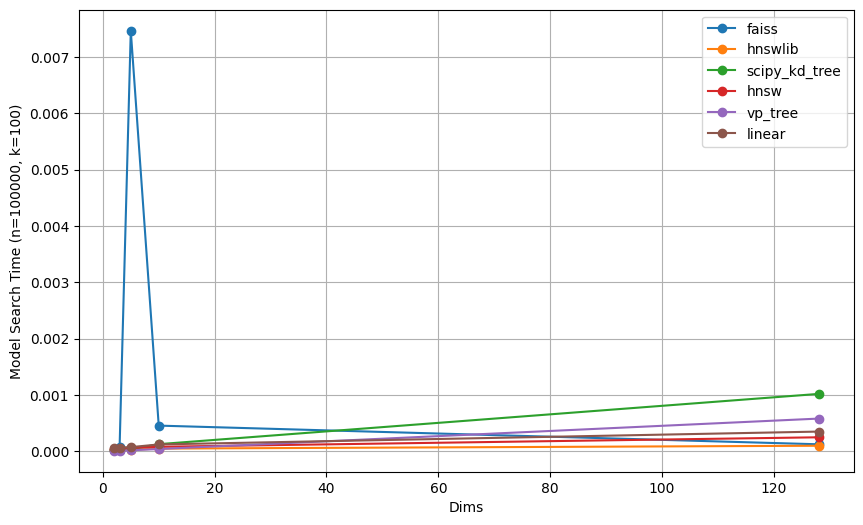

In [72]:
df = mlflow_experiment_stripped("explore3")

plt.figure(figsize=(10, 6))
for model in df["p_model_name"].unique():
    subset = df[(df["p_model_name"] == model) & (df["p_data_n"] == 10000) & (df["p_knn_k"] == 100)]
    subset.sort_values(by="p_data_dims")
    plt.plot(subset["p_data_dims"], subset["m_search_time"], marker='o', label=model)

plt.xlabel("Dims")
plt.ylabel("Model Search Time (n=100000, k=100)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_2350/558762568.py:39: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


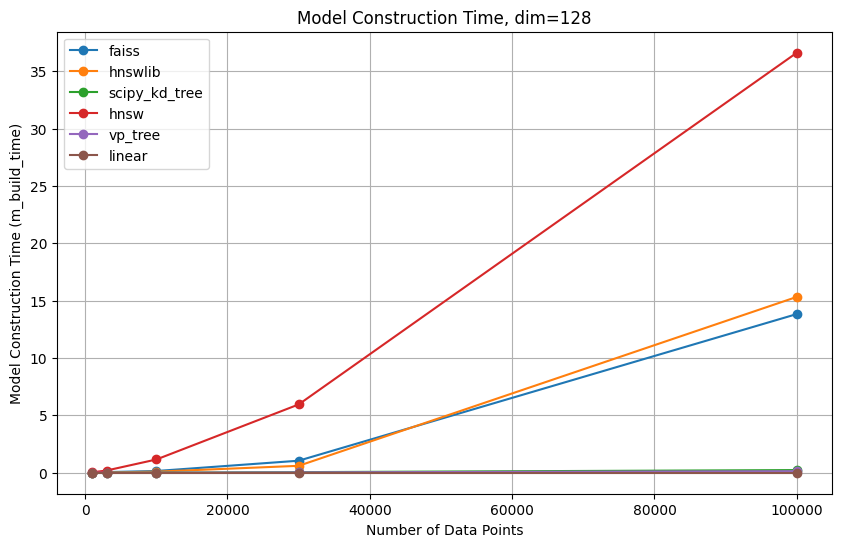

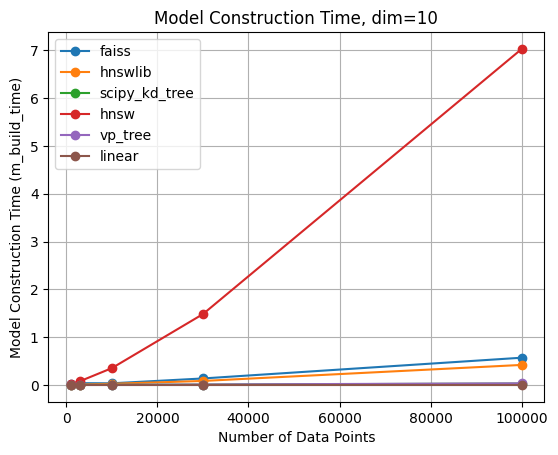

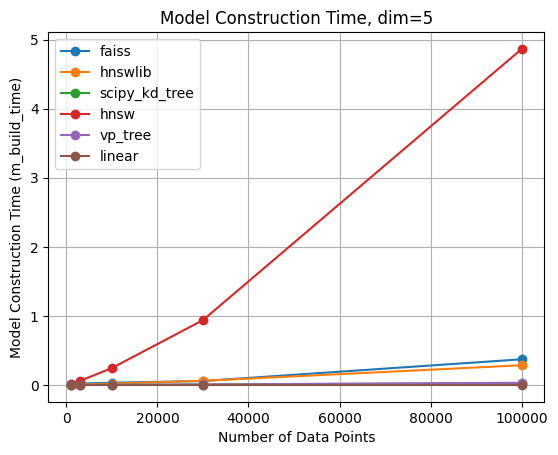

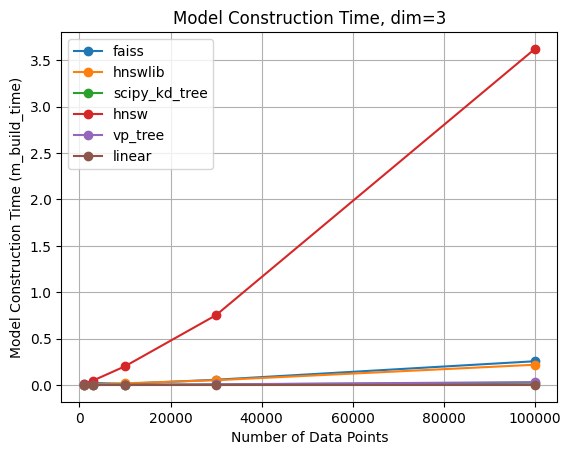

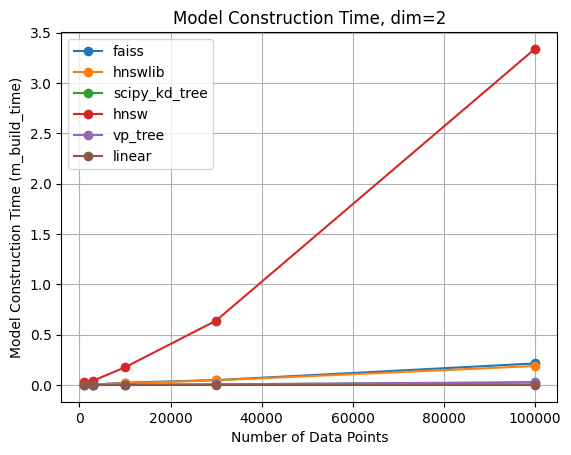

In [56]:
df = mlflow_experiment_stripped("explore3")

plt.figure(figsize=(10, 6))
for dim in df["p_data_dims"].unique():
    for model in df["p_model_name"].unique():
        subset = df[(df["p_model_name"] == model) & (df["p_data_dims"] == dim) & (df["p_knn_k"] == 3)]
        plt.plot(subset["p_data_n"], subset["m_build_time"], marker='o', label=model)

    plt.xlabel("Number of Data Points")
    plt.ylabel("Model Construction Time (m_build_time)")
    plt.title(f"Model Construction Time, dim={dim}")
    plt.legend()
    plt.grid(True)
    plt.show()
